# Train a Stardist model from scratch with a pre-trained encoder

This example shows how to use `cellseg_models.pytorch` for training a [Stardist](https://arxiv.org/abs/1806.03535) model for instance segmentation with pytorch lightning along with the datasets and tools provided by the library.

In [1]:
# !pip install cellseg-models-pytorch

In [2]:
# version info
from platform import python_version

import lightning
import torch

import cellseg_models_pytorch

print("torch version:", torch.__version__)
print("lightning version:", lightning.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.1.1+cu121
lightning version: 2.0.7
cellseg_models_pytorch version: 0.1.25
python version: 3.10.12


## Download data

First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first and the second fold as the training data and the third as the validation data.

Since we will train the [Stardist](https://github.com/stardist/stardist) model, we need to define the right nuclei instance transformations for training time. For Stardist, we define `"stardist"` and `"dist"` transformations. `"stardist"` transforms the labelled instance masks into radial distance maps and `"dist"` transforms the labelled instance masks into regular distance transformation maps. We also set `n_rays=32` to get 32 radial distance maps from the `"stardist"` transform.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"percentile"` normalization for the input images.

In [3]:
from pathlib import Path

from cellseg_models_pytorch.datamodules import PannukeDataModule

# fold1 and fold2 are used for training, fold3 is used for validation
fold_split = {"fold1": "train", "fold2": "train", "fold3": "valid"}

# NOTE The 'pannuke_dataset' directory has to already exist for this to work.
# You can create one in your home folder or just modify the path to your liking,
# The pannuke dataset will be downloaded there.
save_dir = Path.home() / "pannuke_dataset"  # modify the save path
pannuke_module = PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["dist", "stardist"],
    img_transforms=["blur", "hue_sat"],
    normalization="percentile",
    n_rays=32,
)

# NOTE: this will take a while to run
pannuke_module.prepare_data()  # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


**Let's visualize some Pannuke samples**

Here we visualize what kind of data the `PannuDataModule` outputs i.e. the images, nuclei instance masks, and cell type masks. We also visualize the `stardist` and `dist` transformations applied to the instance masks. The `StarDist`-model is going to regress these transformed auxilliary outputs which are later used in post-processing to separate overlapping and clumped nuclei.

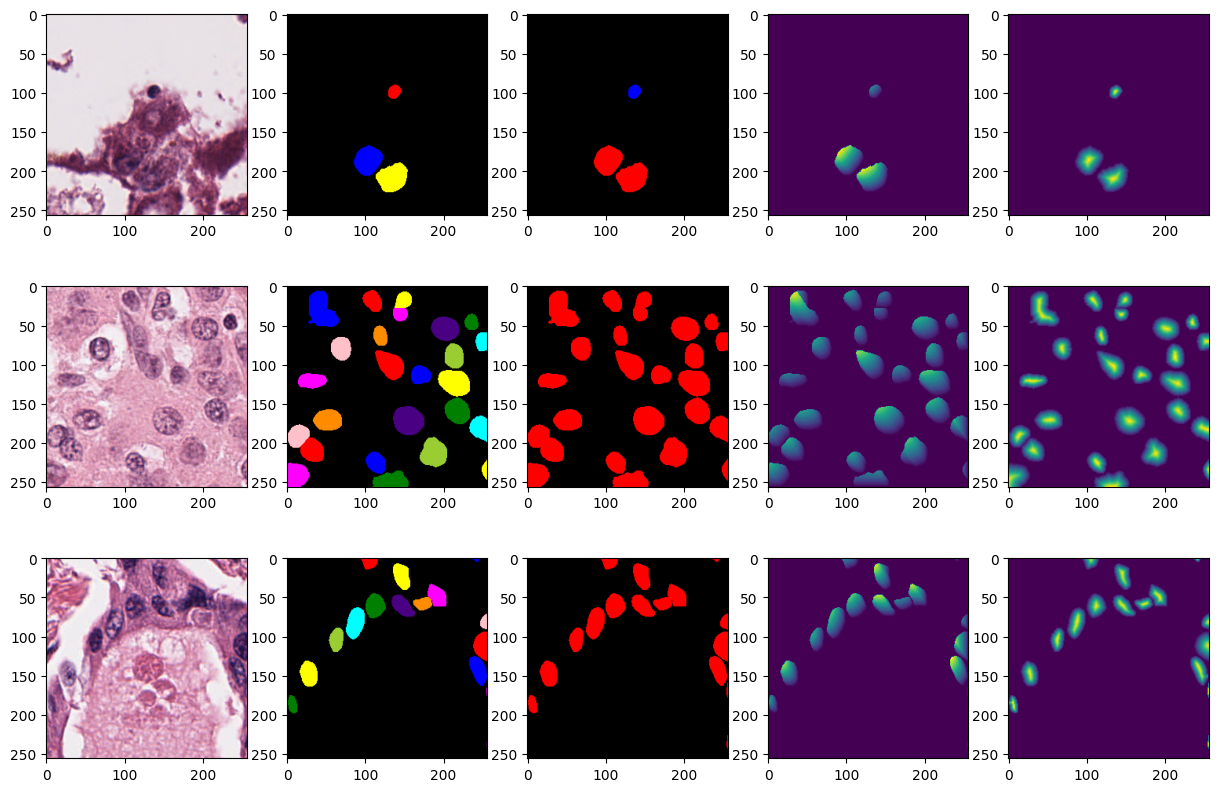

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb

from cellseg_models_pytorch.transforms.functional import (
    gen_dist_maps,
    gen_stardist_maps,
)

# filehandler contains methods to read and write images and masks
from cellseg_models_pytorch.utils import FileHandler

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)

im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
mask1 = FileHandler.read_mat(masks[ixs[0]], return_all=True)
mask2 = FileHandler.read_mat(masks[ixs[1]], return_all=True)
mask3 = FileHandler.read_mat(masks[ixs[2]], return_all=True)

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(gen_stardist_maps(mask1["inst_map"], 32)[5])
ax[4].imshow(gen_dist_maps(mask1["inst_map"]))
ax[5].imshow(im2)
ax[6].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[7].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[8].imshow(gen_stardist_maps(mask2["inst_map"], 32)[5])
ax[9].imshow(gen_dist_maps(mask2["inst_map"]))
ax[10].imshow(im3)
ax[11].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[12].imshow(label2rgb(mask3["type_map"], bg_label=0))
ax[13].imshow(gen_stardist_maps(mask3["inst_map"], 32)[5])
ax[14].imshow(gen_dist_maps(mask3["inst_map"]))

Next, we will define a `SegmentationExperiment`. It is a `pl.LightningModule` wrapper that encapsulates everything needed for training the model. It is a nice way to wrap the model training logic behind a class abstraction. Check out the lightning docs for more: [`lightning`](https://lightning.ai/docs/pytorch/stable/common/trainer.html). We will write the `SegmentationExperiment` to resemble how the actual `Stardist`-model was trained as described in their original paper: https://arxiv.org/pdf/1806.03535.pdf  

**NOTE:**
In the our `SegmentationExperiment`-class, we will have to take into account that the `PannukeDataModule`'s `DataLoader` returns the the inputs and targets in a dictionary like this:
```
{
    "image": torch.Tensor(B, 3, H, W),
    "inst": torch.Tensor(B, H, W),
    "type": torch.Tensor(B, C, H, W)
    "stardist": torch.Tensor(B, 32, H, W)
    "dist": torch.Tensor(B, H, W)
}
```
We will access the `"image"` value in the `step()`-method to run the forward pass of the network.
The rest of the masks will be handled automatically in the multi-task-loss function.



In [5]:
from typing import Dict, List, Optional, Tuple

import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim


class SegmentationExperiment(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        multitask_loss: Dict[str, nn.Module],
        optimizer: optim.Optimizer,
        scheduler: optim.lr_scheduler._LRScheduler,
        optimizer_kwargs: Optional[Dict[str, float]] = None,
        scheduler_kwargs: Optional[Dict[str, float]] = None,
        **kwargs,
    ) -> None:
        """"""
        super().__init__()
        self.model = model
        self.heads = model.heads
        self.aux_key = model.aux_key
        self.inst_key = model.inst_key

        self.optimizer = optimizer
        self.scheduler = scheduler
        self.optimizer_kwargs = optimizer_kwargs or {}
        self.scheduler_kwargs = scheduler_kwargs or {}

        self.criterion = multitask_loss

        self._validate_branch_args()
        self.save_hyperparameters(ignore="model")

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Forward pass."""
        return self.model(x)

    def step(
        self, batch: Dict[str, torch.Tensor]
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """Compute the loss for one batch.

        Parameters
        ----------
            batch : Dict[str, torch.Tensor]
                The batch of data.
            batch_idx : int
                The batch index.

        Returns
        -------
            Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
                The loss, the soft masks and the targets.
        """
        soft_masks = self.model(batch["image"])
        targets = {k: val for k, val in batch.items() if k != "image"}

        loss = self.criterion(
            yhats=soft_masks,
            targets=targets,
            mask=targets["dist"],  # we will use the distance map as a mask
        )

        return loss, soft_masks, targets

    def training_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Training step."""
        # forward backward pass
        loss, _, _ = self.step(batch)

        # log the loss
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Validation step."""
        # forward pass
        loss, _, _ = self.step(batch)

        # log the loss
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def test_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Test step."""
        # forward pass
        loss, _, _ = self.step(batch)

        # log the loss
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def configure_optimizers(self) -> List[optim.Optimizer]:
        """Configure the optimizers for the model."""
        opt = self.optimizer(self.parameters(), **self.optimizer_kwargs)
        sch = self.scheduler(opt, **self.scheduler_kwargs)

        return {
            "optimizer": opt,
            "lr_scheduler": {
                "name": "train/lr",  # we can log the lr if needed
                "scheduler": sch,
                "monitor": "val_loss",
            },
        }

    def _validate_branch_args(self) -> None:
        """Check that there are no conflicting decoder branch args."""
        lk = set([k.split("_")[0] for k in self.criterion.keys()])
        dk = set(self.model._get_inner_keys(self.model.heads))
        has_same_keys = lk == dk

        if not has_same_keys:
            raise ValueError(
                "Got mismatching keys for branch dict args. "
                f"Multitask loss branches: {lk}. "
                f"Decoder branches: {dk}. "
                f"(`branch_metrics` can be None)"
            )

## Prepare the model and training setup and hyperparams

**The model**.
First, we will define the Stardist nuclei segmentation model with a `imagenet` pre-trained encoder. Specifically, we will use the `efficientnetv2` backbone for this demonstration. Many more encoders can be used, since these are imported from the `timm` library. There are also support for some transformer based encoders, but these are shown in another notebooks.

**Branch losses.** For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"stardist"`- we set the masked `MAE`-loss like in the original paper. For the `"dist"`-outputs we use the masked `BCELoss` (binary-cross-entropy) with `MSE`, and for the `"type"`-output we will use the masked multiclass categorical `CELoss` with `DiceLoss`.

**Optimizer and scheduler.**
The optimizer used here is [AdamW](https://arxiv.org/abs/1711.05101). The learning rate is scheduled with the `ReduceLROnPlateau` schedule. The learning rate will be set to 0.0003 like in the original paper. 

**Other hyperparams.**
We will train for 10 epochs (for demo purposes), so the training will probably not converge to the best possible result but anyways the model will learn something.

**NOTE** If torch >= 2.0 we can use the `torch.compile` to compile the model for better performance. Comment out if your pytorch version is less than 2.0 (Remember that the compiled models have bigger memory footprint than non-compiled.). Also, we will train with 16bit precision to lower memory-footprint.

In [19]:
import torch.optim as optim

from cellseg_models_pytorch.losses import (
    MAE,
    MSE,
    BCELoss,
    CELoss,
    DiceLoss,
    JointLoss,
    MultiTaskLoss,
)
from cellseg_models_pytorch.models import stardist_base_multiclass

# seed the experiment for reproducibility
pl.seed_everything(42)

# Define the model with the function API.
model = stardist_base_multiclass(
    enc_name="tf_efficientnetv2_s",
    n_rays=32,  # number of predicted rays
    type_classes=len(pannuke_module.type_classes),
)

# Define the loss-functions for each decoder branch.
# and wrap the losses in a MultiTaskLoss object. Since the Stardist model
# outputs more than one output, it is considered a multi-task model.
branch_losses = {
    "dist": JointLoss([BCELoss(apply_mask=True), MSE()]),
    "type": JointLoss([CELoss(), DiceLoss()]),
    "stardist": MAE(alpha=0.0001, apply_mask=True),
}

multitask_loss = MultiTaskLoss(
    branch_losses=branch_losses,
    loss_weights={"dist": 1.0, "type": 1.0, "stardist": 0.2},  # weights for each branch
)

# Initialize the optimizer.
# We will be using the AdamW optimizer from the torch.optim library with learning rate of 0.0003.
adamw = optim.AdamW
optimizer_kwargs = {"lr": 3e-4}

# Initialize the learning rate scheduler. We will be usin the exponential LR scheduler
# with T_0=3.
scheduler = optim.lr_scheduler.ReduceLROnPlateau
scheduler_kwargs = {"mode": "min"}


# Initialize the segmentation experiment lightning module.
experiment = SegmentationExperiment(
    model=model,
    multitask_loss=multitask_loss,
    optimizer=adamw,
    scheduler=scheduler,
    optimizer_kwargs=optimizer_kwargs,
    scheduler_kwargs=scheduler_kwargs,
)

# If torch >= 2.0 you can use this to compile the model for better performance
# experiment = torch.compile(experiment, mode="default")
# experiment

Global seed set to 42


## Model training with lightning Trainer

In [9]:
# Lightning training
trainer = pl.Trainer(
    accelerator="gpu",
    strategy="auto",  # let lightning decide how to distribute the training.
    precision="16-mixed",  # we'll use 16 bit precision to lower mem-footprint.
    max_epochs=10,
    devices=1,
    enable_progress_bar=True,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
# Train the model
trainer.fit(model=experiment, datamodule=pannuke_module)

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | StarDistUnet  | 23.3 M
1 | criterion | MultiTaskLoss | 0     
--------------------------------------------
23.3 M    Trainable params
0         Non-trainable params
23.3 M    Total params
93.171    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


gg


# Model outputs

Next we will visualize what kind of outputs the model is able to produce after 10 epochs of training. 

Especially, we will look at the `stardist`, `type` and the `dist` maps.

- The `dist` maps are used as the object (nuclei) probability that determine whether the model detects objects as nuclei or not.
- The `stardist` maps on the other hand are used as the input for the NMS-based `stardist`-post-processing pipeline that is used to separate clumped and overlapping nuclei from each other to produce an instance segmentation map. 
- The `type` maps are used to classify the nuclei instances into the `pannuke` cell type classes. Note that the type maps are also post-processed with a majority-voting approach in the post-processing pipeline since typically there is a mixture of different classes within a predicted nuclei as you will see from the type maps below. 

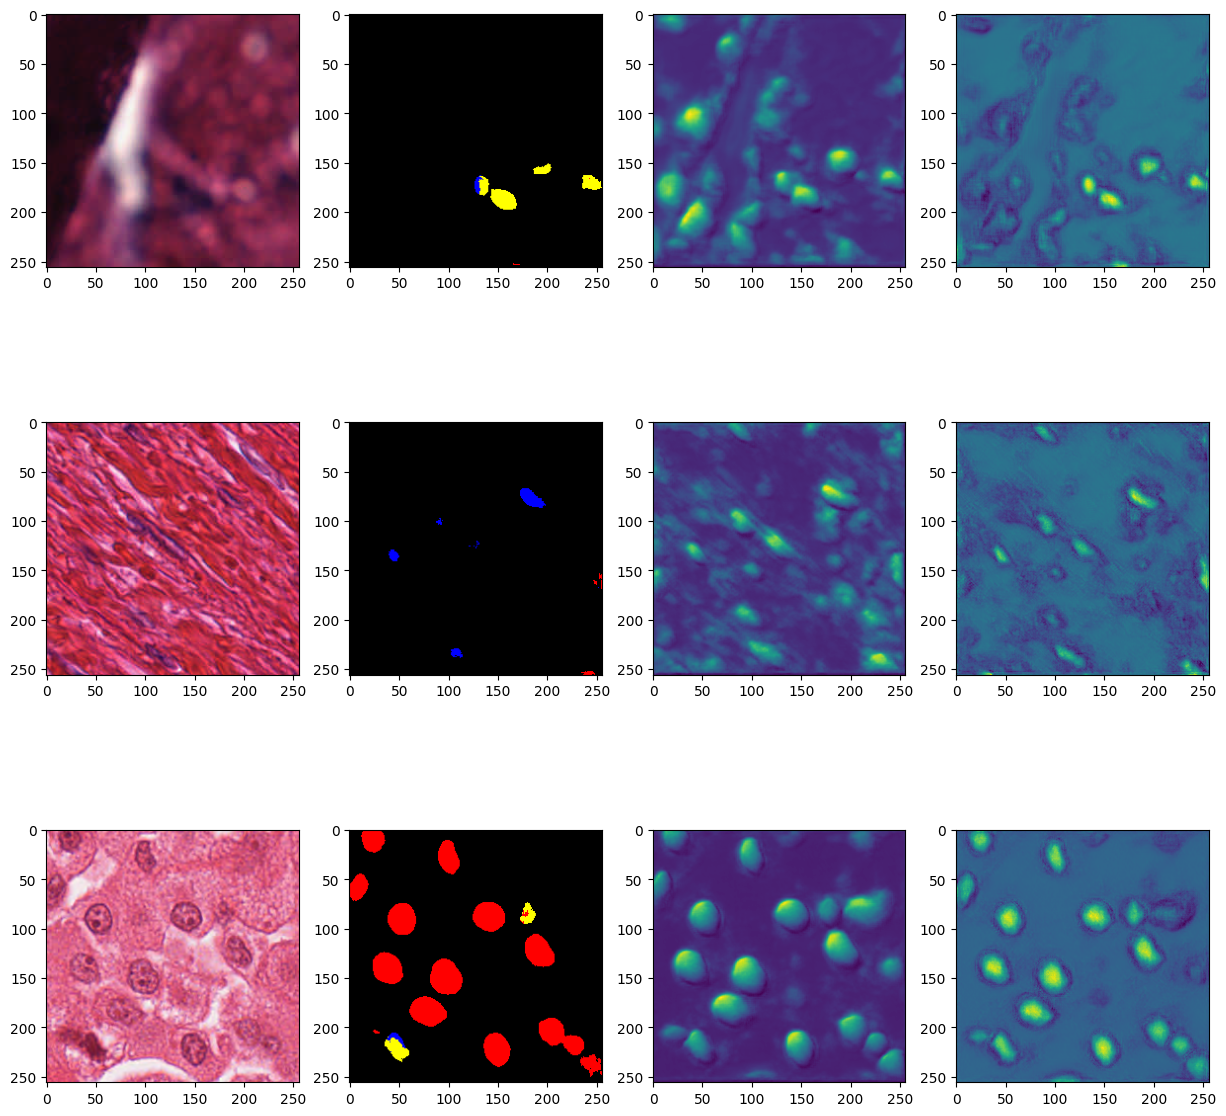

In [14]:
from cellseg_models_pytorch.utils import percentile_normalize

img_dir = save_dir / "valid" / "images"
mask_dir = save_dir / "valid" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)
im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])

img1 = torch.from_numpy(percentile_normalize(im1)).permute(2, 0, 1).unsqueeze(0).float()
img2 = torch.from_numpy(percentile_normalize(im2)).permute(2, 0, 1).unsqueeze(0).float()
img3 = torch.from_numpy(percentile_normalize(im3)).permute(2, 0, 1).unsqueeze(0).float()

pred1 = experiment(img1)
pred2 = experiment(img2)
pred3 = experiment(img3)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(
    label2rgb(
        np.argmax(pred1["type"].squeeze().detach().cpu().numpy(), axis=0), bg_label=0
    )
)
ax[2].imshow(pred1["stardist"].squeeze().detach().cpu().numpy()[5])
ax[3].imshow(pred1["dist"].squeeze().detach().cpu().numpy())
ax[4].imshow(im2)
ax[5].imshow(
    label2rgb(
        np.argmax(pred2["type"].squeeze().detach().cpu().numpy(), axis=0), bg_label=0
    )
)
ax[6].imshow(pred2["stardist"].squeeze().detach().cpu().numpy()[5])
ax[7].imshow(pred2["dist"].squeeze().detach().cpu().numpy())
ax[8].imshow(im3)
ax[9].imshow(
    label2rgb(
        np.argmax(pred3["type"].squeeze().detach().cpu().numpy(), axis=0), bg_label=0
    )
)
ax[10].imshow(pred3["stardist"].squeeze().detach().cpu().numpy()[5])
ax[11].imshow(pred3["dist"].squeeze().detach().cpu().numpy())

## Inference and Post-processing

Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `cellseg_models_pytorch.inference` module. 

Since the Pannuke-dataset has only 256x256px images, we can use the `ResizeInferer` to run the inference and post-processing (without actually resizing the images). The `Inferers` take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-processing method to be used. Here, naturally, we will use `stardist` post-processing since we're running inference for a Stardist model.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the predictions. This can only be useful when inference is run for bigger images that are patched in overlapping patches (inference with overlapping patches can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 50 first images of inside the input folder.

**NOTE**: Another important thing to note here, is that the `"stardist"` post-proc method is not the original one introduced in the [Stardist](https://github.com/stardist/stardist) paper. It is a python rewrite of the original one and can be even twice as fast as the orig one with only neglible differneces in the output. However, if you like, you can use the original by setting `instance_postproc` to `"stardist_orig"`. It should be noted that the original version requires also the original `stardist` library that can be installed with `pip install stardist`.

In [16]:
from cellseg_models_pytorch.inference import ResizeInferer

inferer = ResizeInferer(
    model=experiment,
    input_path=save_dir / "valid" / "images",
    out_activations={"dist": None, "stardist": None, "type": "softmax"},
    out_boundary_weights={"dist": False, "stardist": False, "type": False},
    resize=(256, 256),  # Not actually resizing anything,
    instance_postproc="stardist",
    batch_size=8,
    n_images=50,  # Use only the 50 first images of the folder
    normalization="percentile",
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
)
inferer.infer()

Running inference: 100%|██████████| 7/7 [00:00<00:00,  8.29batch/s, post-processing]


**Let's plot some results**

With only 10 epochs of training, we can get moderate results by just eyeballing.

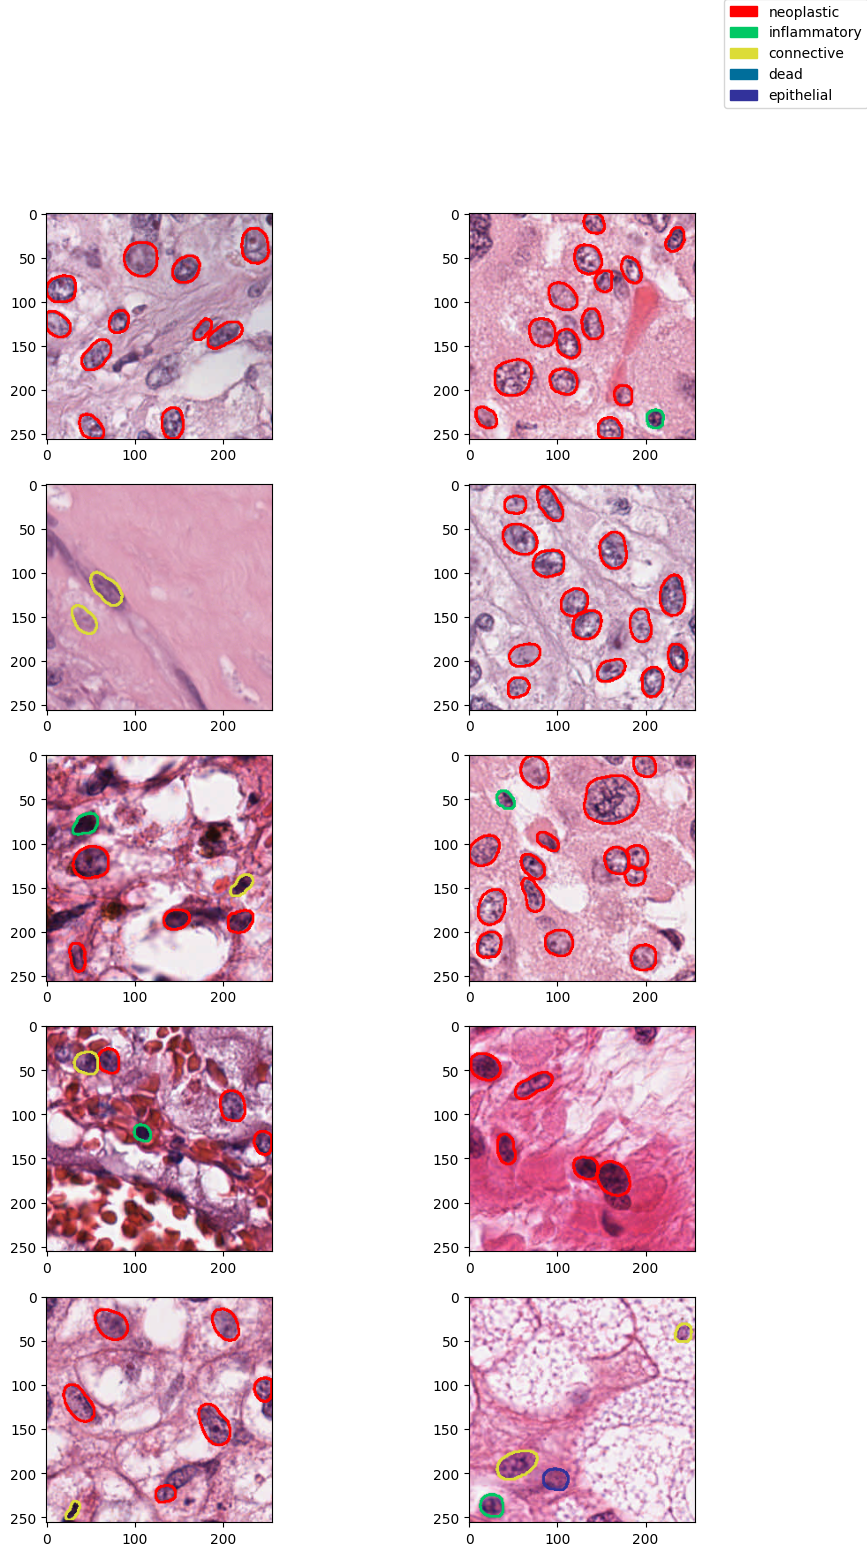

In [17]:
import matplotlib.patches as mpatches
import numpy as np

from cellseg_models_pytorch.utils import draw_thing_contours

fig, ax = plt.subplots(5, 2, figsize=(10, 17))
ax = ax.flatten()
ixs = np.random.choice(50, 10, replace=False)

samples = list(inferer.out_masks.keys())
for i, ix in enumerate(ixs):
    masks = inferer.out_masks[samples[ix]]

    img_path = save_dir / "valid" / f"images/{samples[ix]}.png"
    img = FileHandler.read_img(img_path)
    cont = draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)

# add legend
cmap = {
    1: (255.0 / 255, 0.0, 0.0),
    2: (0.0, 200.0 / 255, 100.0 / 255),
    3: (220.0 / 255, 220.0 / 255, 55.0 / 255),
    4: (0.0, 110.0 / 255, 155.0 / 255),
    5: (50.0 / 255, 50.0 / 255, 155.0 / 255),
}
labels = {k: j for j, k in pannuke_module.type_classes.items()}
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
fig.legend(handles=patches, loc=1, borderaxespad=0)